In [1]:
import pandas as pd

df = pd.read_csv('USvideos.csv', encoding='latin1')  
print(df.columns)
print(df.head())


Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time

In [2]:
print(df.columns.tolist())


['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']


In [3]:
df = df[['video_id', 'title', 'tags', 'views', 'likes', 'comment_count', 'thumbnail_link']]
df.dropna(inplace=True)


In [4]:
#df['is_viral'] = df['likes'] > 10000
df['is_viral'] = (df['likes'] > 10000) & (df['views'] > 1_000_000)


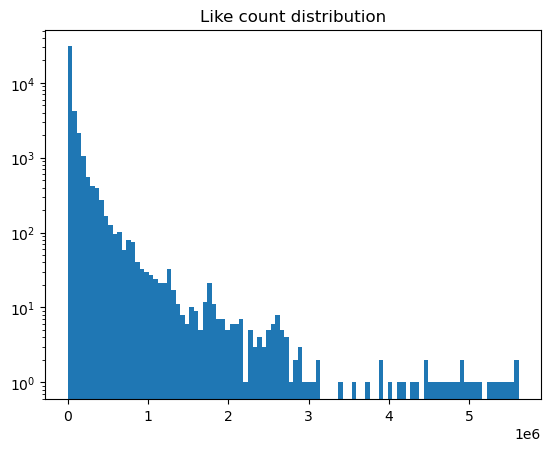

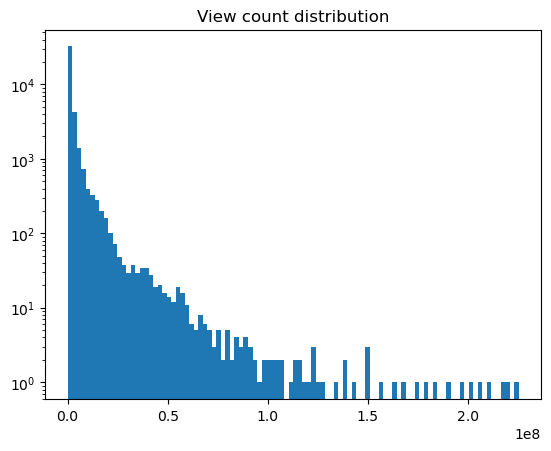

In [5]:
import matplotlib.pyplot as plt

plt.hist(df['likes'], bins=100, log=True)
plt.title("Like count distribution")
plt.show()

plt.hist(df['views'], bins=100, log=True)
plt.title("View count distribution")
plt.show()


In [6]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [10]:
# =============================
# Just Kaggle small dataset 
# =============================
# def of（viral） 
df['is_viral'] = (df['likes'] > 10000) & (df['views'] > 1_000_000)

# =============================
# the tumbnail column in csv(pic)
# =============================
import os
import requests

os.makedirs('thumbnails', exist_ok=True)

def download_thumbnail(row):
    video_id = row['video_id']
    url = row['thumbnail_link']
    path = f'thumbnails/{video_id}.jpg'
    if not os.path.exists(path):
        try:
            r = requests.get(url, timeout=10)
            with open(path, 'wb') as f:
                f.write(r.content)
            print(f'Downloaded: {video_id}')
        except Exception as e:
            print(f'Failed: {video_id} - {e}')

df.head(100).apply(download_thumbnail, axis=1)  # 先下载100张图

# =============================
# get vec
# =============================
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  # 去掉分类层
resnet = resnet.to(device)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_image_feature(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = resnet(img_tensor)
        return features.squeeze().cpu().numpy()
    except:
        return None

features = []
for vid in tqdm(df['video_id'].head(100)):
    path = f'thumbnails/{vid}.jpg'
    if os.path.exists(path):
        vec = extract_image_feature(path)
    else:
        vec = None
    features.append(vec)

df = df.head(100).copy()
df['image_feature'] = features
df = df[df['image_feature'].notnull()]  # del null

# =============================
# stand
# =============================
from sklearn.preprocessing import StandardScaler

X_num = df[['views', 'likes', 'comment_count']]
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X_img = np.vstack(df['image_feature'].values)
X = np.hstack([X_img, X_num_scaled])
y = df['is_viral'].astype(int).values

# =============================
# log reg
# =============================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.00it/s]

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.40      0.40      0.40         5

    accuracy                           0.70        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.70      0.70      0.70        20



In [ ]:

import torch.nn as nn

class MixedMLP(nn.Module):
    def __init__(self, input_dim=515):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # use sigmoid for this one
        )

    def forward(self, x):
        return self.net(x)
import torch
from torch.utils.data import TensorDataset, DataLoader

# just the pipeline
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# loss opt 
model = MixedMLP(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#train
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

model.eval()
with torch.no_grad():
    pred = model(X_tensor.to(device)).cpu().numpy()
    pred_class = (pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y, pred_class))

NameError: name 'X' is not defined